In [1]:
from torch_geometric.datasets import TUDataset
from torch_geometric.data import DataLoader

In [2]:
dataset = TUDataset(root="TUDataset", name="MUTAG")

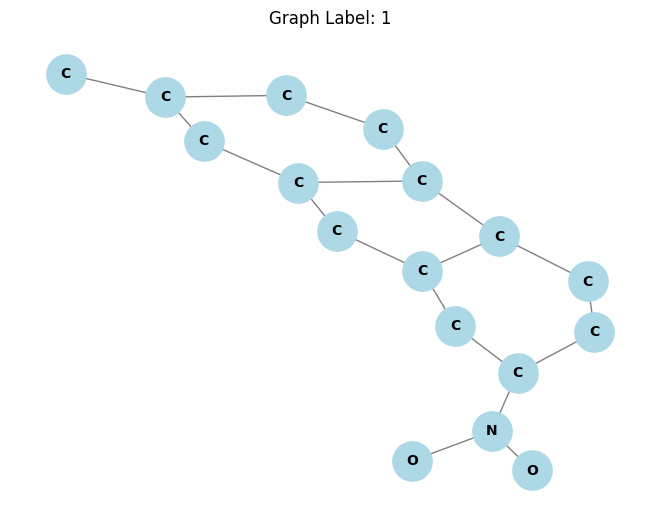

In [3]:
import networkx as nx
from torch_geometric.utils import to_networkx
from matplotlib import pyplot as plt
import random

data = dataset[9]
G = to_networkx(data, to_undirected=True)

pos = nx.spring_layout(G) 
atom_types = ["C", "N", "O", "F", "I", "Cl", "Br"]

node_labels = {i: atom_types[x.argmax().item()] for i, x in enumerate(data.x)}
nx.draw(G, pos, labels=node_labels, node_color="lightblue", edge_color="gray", node_size=800, font_size=10, font_weight="bold")
# show label graph
y = data.y.item()
plt.title(f"Graph Label: {y}")
plt.show()

In [3]:
train_dataset, val_dataset, test_dataset = dataset[:150], dataset[150:169], dataset[169:]

print(f'Training set   = {len(train_dataset)} graphs')
print(f'Validation set = {len(val_dataset)} graphs')
print(f'Test set       = {len(test_dataset)} graphs')
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Training set   = 150 graphs
Validation set = 19 graphs
Test set       = 19 graphs


/Users/admin/Documents/Screenshots/LORE/.env/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [4]:
import sys
import os

# Lấy đường dẫn thư mục gốc (project_root)
project_root = os.path.abspath(os.path.join(os.path.dirname('model'), ".."))
sys.path.append(project_root)

In [5]:
import torch
from torch_geometric.data import DataLoader
from model.gin import GIN

device = "cuda" if torch.cuda.is_available() else "cpu"
model = GIN(
        in_channels=dataset.num_features,
        hidden_channels=32,
        out_channels=dataset.num_classes,
        num_layers=5,
    ).to(device)


In [6]:
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GINConv, global_add_pool

def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch, data.batch_size)
        loss = F.cross_entropy(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
    return total_loss / len(train_loader.dataset)

@torch.no_grad()
def test(loader):
    model.eval()
    total_correct = 0
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch, data.batch_size)
        pred = out.argmax(dim=-1)
        total_correct += int((pred == data.y).sum())
    return total_correct / len(loader.dataset)

In [7]:
import time
times = []
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
for epoch in range(1, 201):
    start = time.time()
    loss = train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    times.append(time.time() - start)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, '
          f'Test: {test_acc:.4f}')
print(f'Median time per epoch: {torch.tensor(times).median():.4f}s')

Epoch: 001, Loss: 0.6422, Train: 0.6600, Test: 0.6316
Epoch: 002, Loss: 0.5706, Train: 0.6600, Test: 0.6316
Epoch: 003, Loss: 0.5305, Train: 0.6600, Test: 0.6316
Epoch: 004, Loss: 0.4963, Train: 0.6600, Test: 0.6316
Epoch: 005, Loss: 0.5217, Train: 0.6600, Test: 0.6316
Epoch: 006, Loss: 0.4173, Train: 0.8267, Test: 0.5789
Epoch: 007, Loss: 0.3691, Train: 0.8800, Test: 0.7368
Epoch: 008, Loss: 0.3482, Train: 0.8733, Test: 0.8421
Epoch: 009, Loss: 0.3720, Train: 0.8933, Test: 0.7368
Epoch: 010, Loss: 0.3433, Train: 0.9067, Test: 0.6316
Epoch: 011, Loss: 0.3037, Train: 0.9067, Test: 0.7368
Epoch: 012, Loss: 0.3247, Train: 0.9200, Test: 0.8947
Epoch: 013, Loss: 0.3111, Train: 0.9267, Test: 0.8421
Epoch: 014, Loss: 0.2946, Train: 0.9400, Test: 0.7368
Epoch: 015, Loss: 0.2414, Train: 0.9267, Test: 0.8421
Epoch: 016, Loss: 0.2541, Train: 0.9267, Test: 0.7895
Epoch: 017, Loss: 0.2594, Train: 0.9467, Test: 0.7368
Epoch: 018, Loss: 0.2204, Train: 0.9533, Test: 0.7895
Epoch: 019, Loss: 0.2026, Tr

In [8]:
# save
torch.save(model.state_dict(), "../model/model_mutag.pth")

In [6]:
model.load_state_dict(torch.load(project_root + "/model/model_mutag.pth"))

<All keys matched successfully>

In [7]:
from model.gin import prepare_dataframe
model.eval()

GIN(
  (convs): ModuleList(
    (0): GINConv(nn=Sequential(
      (0): Linear(in_features=7, out_features=64, bias=True)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=64, out_features=32, bias=True)
    ))
    (1-4): 4 x GINConv(nn=Sequential(
      (0): Linear(in_features=32, out_features=64, bias=True)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=64, out_features=32, bias=True)
    ))
  )
  (batch_norms): ModuleList(
    (0-4): 5 x BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (mlp): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=32, out_features=2, bias=True)
  )
)

In [167]:
from sklearn.preprocessing import normalize
from model.gin import *
import random

class GraphGenome:
    def __init__(self, data):
        self.num_nodes = data.x.size(0)
        self.x = data.x.clone()
        self.edge_index = data.edge_index.clone()
        self.fitness = 0
    
    def clone(self):
        return GraphGenome(Data(x=self.x.clone(), edge_index=self.edge_index.clone()))
    
    def eval_fitness_sso(self, graphX, blackbox, distance_function, alpha1, alpha2):
        y_X, embedding_X = blackbox.predict(graphX.x, ensure_undirected(graphX.edge_index), None, 1, True)
        y_G, embedding_G = blackbox.predict(self.x, ensure_undirected(self.edge_index), None, 1, True)
        max_nodes = max(self.num_nodes, graphX.x.size(0))
        if embedding_X.shape[0] < max_nodes:
            padding_size = max_nodes - embedding_X.shape[0]
            padding = torch.zeros((padding_size, embedding_X.shape[1]))  # Vector zero có cùng số feature
            embedding_X = torch.cat((embedding_X, padding), dim=0)
        if embedding_G.shape[0] < max_nodes:
            padding_size = max_nodes - embedding_G.shape[0]
            padding = torch.zeros((padding_size, embedding_G.shape[1]))  # Vector zero có cùng số feature
            embedding_G = torch.cat((embedding_G, padding), dim=0)
        embedding_X = embedding_X.mean(dim=1).detach().numpy()
        embedding_G = embedding_G.mean(dim=1).detach().numpy()
        embedding1_normalized = normalize(embedding_X.reshape(1, -1))[0]
        embedding2_normalized = normalize(embedding_G.reshape(1, -1))[0]
        distance = np.linalg.norm(embedding1_normalized - embedding2_normalized)
        similarity = 1.0 - distance
        similarity = 0.0 if similarity >= 0.8 else similarity
        
        target_similarity = 1.0 if y_X == y_G else 0.0
        
        print('record_similarity: ', similarity, '-- evaluation: ', target_similarity)
        return alpha1 * similarity + alpha2 * target_similarity
    
    def eval_fitness_sdo(self, graphX, blackbox, distance_function, alpha1, alpha2):
        y_X, embedding_X = blackbox.predict(graphX.x, ensure_undirected(graphX.edge_index), None, 1, True)
        y_G, embedding_G = blackbox.predict(self.x, ensure_undirected(self.edge_index), None, 1, True)
        max_nodes = max(self.num_nodes, graphX.x.size(0))
        if embedding_X.shape[0] < max_nodes:
            padding_size = max_nodes - embedding_X.shape[0]
            padding = torch.zeros((padding_size, embedding_X.shape[1]))  # Vector zero có cùng số feature
            embedding_X = torch.cat((embedding_X, padding), dim=0)

        # Padding cho embedding2 nếu số node ít hơn max_nodes
        if embedding_G.shape[0] < max_nodes:
            padding_size = max_nodes - embedding_G.shape[0]
            padding = torch.zeros((padding_size, embedding_G.shape[1]))  # Vector zero có cùng số feature
            embedding_G = torch.cat((embedding_G, padding), dim=0)
        embedding_X = embedding_X.mean(dim=1).detach().numpy()
        embedding_G = embedding_G.mean(dim=1).detach().numpy()
        embedding1_normalized = normalize(embedding_X.reshape(1, -1))[0]
        embedding2_normalized = normalize(embedding_G.reshape(1, -1))[0]
        distance = np.linalg.norm(embedding1_normalized - embedding2_normalized)
        similarity = 1.0 - distance
        similarity = 0.0 if similarity >= 0.8 else similarity
        
        target_similarity = 1.0 if y_X != y_G else 0.0
        
        print('record_similarity: ', similarity, '-- evaluation: ', target_similarity)
        return alpha1 * similarity + alpha2 * target_similarity
    
    def mutate(self, graphX, blackbox, distance_function, alpha1, alpha2, case_type):
        edge_list = set(tuple(edge.tolist()) for edge in self.edge_index.T)
        num_nodes = self.num_nodes
        mutation_type = random.choice(["add_edge", "remove_edge", "add_node", "remove_node"])
        node_x_type = "discrete" if torch.all((self.x[0] == 0) | (self.x[0] == 1)) else "continuous"
        new_x = self.x.clone()
        if mutation_type == "add_edge":
            u, v = random.sample(range(num_nodes), 2)
            edge = (u, v) if u < v else (v, u)
            if edge not in edge_list:
                edge_list.add(edge)

        elif mutation_type == "remove_edge" and edge_list:
            edge = random.choice(list(edge_list))
            edge_list.remove(edge)

        elif mutation_type == "add_node":
            if node_x_type == "discrete":
                new_node_feature = torch.zeros_like(self.x[0])
                new_category = random.randint(0, new_node_feature.size(0) - 1)
                new_node_feature[new_category] = 1
            else:
                new_node_feature = torch.tensor([0.1] * 10)
            
            k = min(1, num_nodes)  
            neighbors = random.sample(range(num_nodes), k)
            for neighbor in neighbors:
                edge_list.add((num_nodes, neighbor))

            self.num_nodes += 1
            
            new_x = torch.cat([self.x, new_node_feature.unsqueeze(0)], dim=0)

        elif mutation_type == "remove_node" and num_nodes > 1:
            remove_node = random.randint(0, num_nodes - 1)
            edge_list = {(u, v) for u, v in edge_list if remove_node not in (u, v)}

            # # Cập nhật index để không bị "lỗ hổng" trong edge_index
            mapping = {old_idx: new_idx for new_idx, old_idx in enumerate(set(range(num_nodes)) - {remove_node})}
            edge_list = {(mapping[u], mapping[v]) for u, v in edge_list if u in mapping and v in mapping}

            new_x = torch.cat([self.x[:remove_node], self.x[remove_node+1:]], dim=0)

            self.num_nodes -= 1
        else:
            new_x = self.x.clone()
        
        new_edge_index = torch.tensor(list(edge_list), dtype=torch.long).T

        # thay doi feature vector cua 1 node
        mutation_rate = 0.1
        for i in range(self.num_nodes):
            if random.random() < mutation_rate:
                if torch.all((new_x[i] == 0) | (new_x[i] == 1)):  
                    current_category = torch.argmax(new_x[i]).item()
                    new_category = random.choice([j for j in range(new_x.size(1)) if j != current_category])
                    new_x[i] = torch.zeros_like(new_x[i])
                    new_x[i][new_category] = 1
                else:
                    noise = torch.randn_like(new_x[i]) * 0.05
                    new_x[i] = torch.nn.functional.softmax(new_x[i] + noise, dim=0)
                
        mutated_graph = GraphGenome(Data(x=new_x, edge_index=new_edge_index))
        
        if case_type == 'sso':
            mutated_graph.fitness = mutated_graph.eval_fitness_sso(graphX, blackbox, distance_function, alpha1, alpha2)
        else:  
            mutated_graph.fitness = mutated_graph.eval_fitness_sdo(graphX, blackbox, distance_function, alpha1, alpha2)
            
        return mutated_graph
    
    def crossover(self, other, graphX, blackbox, distance_function, alpha1, alpha2, case_type):
        # cat doan edge tu cha va me
        parent1_edges = [tuple(edge.tolist()) for edge in self.edge_index.T]
        parent2_edges = [tuple(edge.tolist()) for edge in other.edge_index.T]

        if len(parent1_edges) < 2 or len(parent2_edges) < 2:
            return self  
        cut1, cut2 = sorted(random.sample(range(len(parent1_edges)), 2))
        edge_added = parent2_edges[cut1:cut2]
        after_reindx_edges = []
        for (u, v) in edge_added:
            if u > self.num_nodes:  # Cập nhật node u nếu cần
                after_reindx_edges.append((self.num_nodes, u))
                self.num_nodes += 1
            else:
                after_reindx_edges.append((u, v))

            if v > self.num_nodes:  # Cập nhật node v nếu cần
                after_reindx_edges.append((self.num_nodes, v))
                self.num_nodes += 1
            else:
                after_reindx_edges.append((u, v))

        # Loại bỏ các cạnh trùng lặp, đảm bảo không thay đổi thứ tự
        edge_added = list({tuple(sorted(edge)) for edge in after_reindx_edges})

        # Ghép các phần của graph lại với nhau
        child_edges = parent1_edges[:cut1] + edge_added + parent1_edges[cut2:]

        # Loại bỏ các cạnh trùng lặp trong toàn bộ graph
        child_edges = list({tuple(sorted(edge)) for edge in child_edges})

        # Cập nhật chỉ mục cho new_edge_index
        new_edge_index = torch.tensor(child_edges, dtype=torch.long).T

        nodes_in_child = set(node for edge in child_edges for node in edge)
        
        new_x = list(self.x) 
        num_nodes_self = self.x.size(0)
        num_nodes_other = other.x.size(0)

        # # Cập nhật feature matrix
        for node in sorted(nodes_in_child):
            if node >= num_nodes_self and node < num_nodes_other:
                new_x.append(other.x[node])
        new_x = torch.stack(new_x, dim=0)
        
        child = GraphGenome(Data(x=new_x, edge_index=new_edge_index))
        if case_type == 'sso':
            child.fitness = child.eval_fitness_sso(graphX, blackbox, distance_function, alpha1, alpha2)
        else: 
            child.fitness = child.eval_fitness_sdo(graphX, blackbox, distance_function, alpha1, alpha2)

        return child



def initialize_population(size, graph, blackbox, distance_function, alpha1, alpha2, case_type):
    population = [GraphGenome(graph.to(device)) for _ in range(size)]
    for individual in population:
        if case_type == 'sso':
            individual.fitness = individual.eval_fitness_sso(graph, blackbox, distance_function, alpha1, alpha2)
        else:  
            individual.fitness = individual.eval_fitness_sdo(graph, blackbox, distance_function, alpha1, alpha2)
            
    return population

def select_parents(population, ratio):
    population.sort(key=lambda individual: individual.fitness, reverse=True)
    return population[:int(ratio * len(population))]

def genetic_algorithm(graphX, populationSize, generations, blackbox, distance_function, alpha1, alpha2):
    case_population_size = populationSize // 2
    case_type = ['sso', 'sdo']
    populations = {}
        
    for type in case_type:
        populations[type] = initialize_population(
                    case_population_size, graphX, blackbox, distance_function, alpha1, alpha2, type
                )
        for gen in range(generations):
            print(f"{type} : Generation {gen+1}/{generations} =====")
            new_population = []
            best_individuals = select_parents(populations[type], 0.1)
            new_population.extend(best_individuals[:len(best_individuals) // 2])
            while len(new_population) < case_population_size:
                parent1, parent2 = random.sample(best_individuals, 2)
                child = parent1.crossover(parent2, graphX, blackbox, distance_function, alpha1, alpha2, type)
                if random.random() < 0.2:
                    child = child.mutate(graphX, blackbox, distance_function, alpha1, alpha2, type)
                new_population.append(child)
                    
            populations[type] = new_population
            
    final_population = []
    for population in populations.values():
        final_population.extend(population)
        
    return final_population

In [168]:
from distance import *

graphX = dataset[0]
populations = genetic_algorithm(graphX=graphX, populationSize=400, generations=10, 
                                blackbox= model, distance_function=my_distance2, alpha1=0.5, alpha2 = 0.5)

record_similarity:  0.0 -- evaluation:  1.0
record_similarity:  0.0 -- evaluation:  1.0
record_similarity:  0.0 -- evaluation:  1.0
record_similarity:  0.0 -- evaluation:  1.0
record_similarity:  0.0 -- evaluation:  1.0
record_similarity:  0.0 -- evaluation:  1.0
record_similarity:  0.0 -- evaluation:  1.0
record_similarity:  0.0 -- evaluation:  1.0
record_similarity:  0.0 -- evaluation:  1.0
record_similarity:  0.0 -- evaluation:  1.0
record_similarity:  0.0 -- evaluation:  1.0
record_similarity:  0.0 -- evaluation:  1.0
record_similarity:  0.0 -- evaluation:  1.0
record_similarity:  0.0 -- evaluation:  1.0
record_similarity:  0.0 -- evaluation:  1.0
record_similarity:  0.0 -- evaluation:  1.0
record_similarity:  0.0 -- evaluation:  1.0
record_similarity:  0.0 -- evaluation:  1.0
record_similarity:  0.0 -- evaluation:  1.0
record_similarity:  0.0 -- evaluation:  1.0
record_similarity:  0.0 -- evaluation:  1.0
record_similarity:  0.0 -- evaluation:  1.0
record_similarity:  0.0 -- evalu

Fitness: 0.89617455


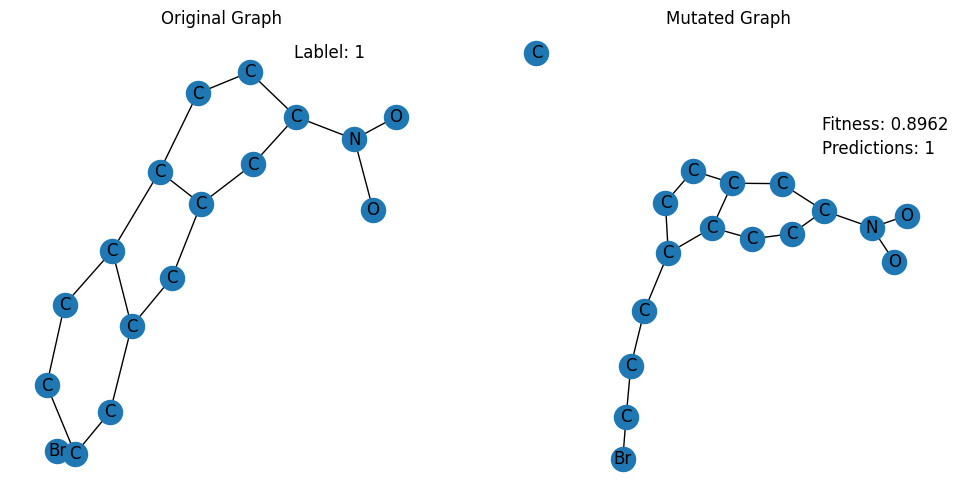

In [172]:
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt

index = random.randint(0, len(populations) - 1)
print("Fitness:", populations[index].fitness)
graph_neig = Data(x=populations[index].x, edge_index=populations[index].edge_index)
atom_types = ["C", "N", "O", "F", "I", "Cl", "Br"]

node_labels_ori = {i: atom_types[x.argmax().item()] for i, x in enumerate(graphX.x)}
node_labels = {i: atom_types[x.argmax().item()] for i, x in enumerate(graph_neig.x)}
def layout(G):
    return nx.spring_layout(G, seed=42)

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title("Original Graph")
plt.text(0.5, 0.5, "Lablel: {}".format(graphX.y.item()), fontsize=12)
G_original = to_networkx(graphX, to_undirected=True)
pos = layout(G_original)  
nx.draw(G_original, labels=node_labels_ori, with_labels=True, pos=pos)

plt.subplot(122)
plt.title("Mutated Graph")
plt.text(0.5, 0.5, "Fitness: {:.4f}".format(populations[index].fitness), fontsize=12)
plt.text(0.5, 0.4, "Predictions: {}".format(model.predict(graph_neig.x, ensure_undirected(graph_neig.edge_index), None,1)), fontsize=12)
G_mutated = to_networkx(graph_neig, to_undirected=True)
nx.draw(G_mutated, labels = node_labels, with_labels=True)
plt.show()

In [126]:
print(graph_neig.x.shape)
graph_neig.x

torch.Size([18, 7])


tensor([[1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.]])

['blue', 'blue', 'green', 'blue', 'green', 'blue', 'blue', 'blue', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'blue', 'red', 'red', 'blue', 'red', 'red', 'blue', 'blue', 'blue', 'red', 'red', 'blue', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'blue', 'red', 'red', 'blue', 'green', 'blue', 'green', 'blue']


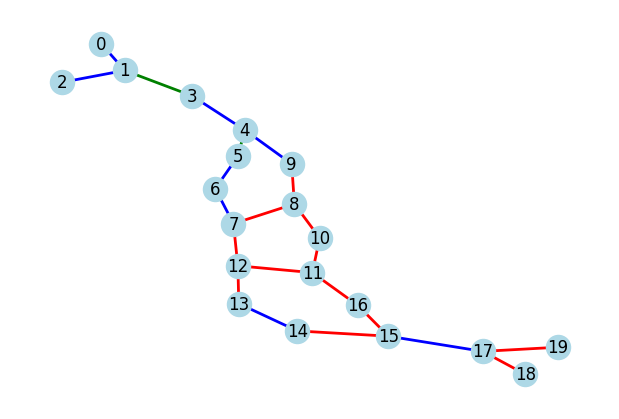

In [14]:
data = dataset[7]
G = to_networkx(data, edge_attrs=['edge_attr'], to_undirected=True)

edge_attrs = data.edge_attr.argmax(dim=1).tolist() 

# Loai lien kết: 0: aromatic, 1: single, 2: double, 3: triple
edge_color_list = ['red', 'blue', 'green', 'grey']  
edge_colors = [edge_color_list[attr] for attr in edge_attrs]
print(edge_colors)

plt.figure(figsize=(6, 4))
pos = nx.spring_layout(G, seed=42) 
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color=edge_colors, width=2)

plt.show()

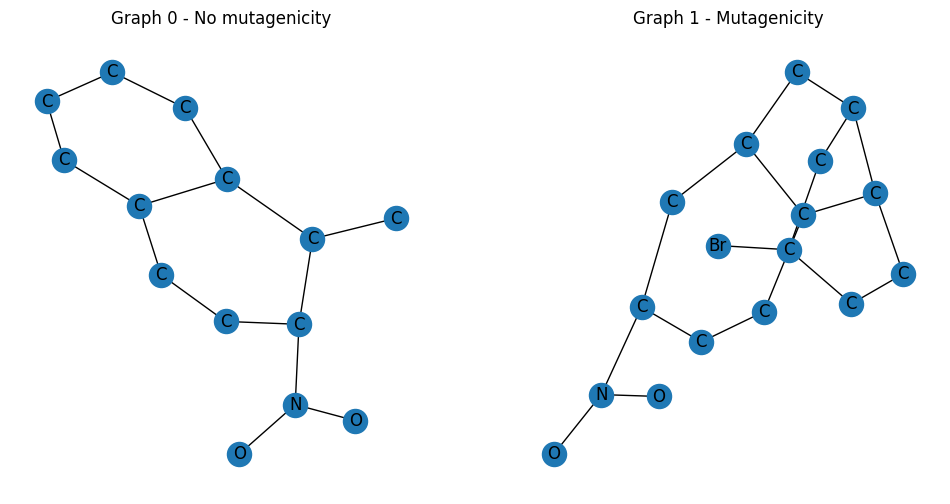

In [74]:
dataset = dataset.shuffle()
graph_0 = (graph for graph in dataset if graph.y.item() == 0).__next__()
graph_1 = (graph for graph in dataset if graph.y.item() == 1).__next__()
atom_types = ["C", "N", "O", "F", "I", "Cl", "Br"]

node_labels_ori = {i: atom_types[x.argmax().item()] for i, x in enumerate(graph_0.x)}
node_labels = {i: atom_types[x.argmax().item()] for i, x in enumerate(graph_1.x)}
def layout(G):
    return nx.spring_layout(G, seed=42)

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title("Graph 0 - No mutagenicity")
G_0 = to_networkx(graph_0, to_undirected=True)
pos = layout(G_0)  
nx.draw(G_0, labels=node_labels_ori, with_labels=True, pos=pos)

plt.subplot(122)
plt.title("Graph 1 - Mutagenicity")
G_1 = to_networkx(graph_1, to_undirected=True)
nx.draw(G_1, labels = node_labels, with_labels=True)
plt.show()

In [152]:
import pandas as pd
def create_adjacency_matrix(edge_index, num_nodes):
    adj_matrix = torch.zeros((num_nodes, num_nodes), dtype=torch.int)
    if edge_index.numel() > 0:  
        for i in range(edge_index.size(1)):
            src, dst = edge_index[0, i].item(), edge_index[1, i].item()
            adj_matrix[src, dst] = 1
            adj_matrix[dst, src] = 1  
    return adj_matrix

def ensure_undirected(edge_index):
    edge_set = set()
    unique_edges = []
    
    for i in range(edge_index.shape[1]):
        u, v = edge_index[:, i].tolist()
        edge = tuple(sorted((u, v)))
        
        if edge not in edge_set:
            edge_set.add(edge)
            unique_edges.append([u, v])

    bidirectional_edges = []
    for u, v in unique_edges:
        bidirectional_edges.append([u, v])
        bidirectional_edges.append([v, u])
    
    return torch.tensor(bidirectional_edges, dtype=torch.long).T

def prepare_dataframe(list_graph, model, device, ground_truth = False, get_edge = True, get_embedding = False, get_node_label = False):
    all_embeddings = []
    edge_dicts = []
    labels = []
    node_labels = []
    model.eval() 
    
    with torch.no_grad():
        for graph in list_graph:
            x = graph.x.to(device)
            edge_index = ensure_undirected(graph.edge_index).to(device)

            if get_embedding:
            # tinh node embeddings va lay mean
                _, node_embeddings = model(x, edge_index, None, 1, return_embeddings=True)
                mean_node_embedding = node_embeddings.mean(dim=1).cpu().numpy()
                all_embeddings.append(mean_node_embedding.tolist())
            
            # tao ma tran ke va chuyen thanh dict
            num_nodes = graph.num_nodes
            adj_matrix = create_adjacency_matrix(graph.edge_index.cpu(), num_nodes)
            edge_dict = {f'n{r}_n{c}': adj_matrix[r, c].item() 
                         for r in range(num_nodes) for c in range(r, num_nodes)}
            edge_dicts.append(edge_dict)
            
            # y tu data hoac model
            if ground_truth:
                labels.append(graph.y.item())
            else :
                prediction = model.predict(x, edge_index, None, 1)
                labels.append(prediction.item())
            
            # node labels
            atom_types = ["C", "N", "O", "F", "I", "Cl", "Br"]
            # node_labels = {i: atom_types[x.argmax().item()] for i, x in enumerate(data.x)}  
            if get_node_label:
                node_label_list = [atom_types[x.argmax().item()] for x in x]
                node_labels.append(node_label_list)
                

    max_embed_dim = max(len(embed) for embed in all_embeddings) if all_embeddings else 0
    embed_columns = [f'nE_{i}' for i in range(max_embed_dim)]
    
    result_df = pd.DataFrame()
    if node_labels:
        df_node_labels = pd.DataFrame(node_labels)
        result_df = pd.concat([result_df, df_node_labels], axis=1)
    if all_embeddings:
        df_embeddings = pd.DataFrame(all_embeddings, columns=embed_columns)
        result_df = pd.concat([result_df, df_embeddings], axis=1)
    if get_edge:
        df_edges = pd.DataFrame(edge_dicts).fillna(0).astype(int)
        result_df = pd.concat([result_df, df_edges], axis=1)

         
    result_df['y'] = labels
    
    return result_df

df = prepare_dataframe(populations, model, device, ground_truth=False, get_edge = False, get_embedding = False, get_node_label = True)
df[:20]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,y
0,C,C,C,C,C,C,N,Cl,O,C,C,C,C,C,C,C,Br,None,1
1,C,C,C,C,C,C,N,Cl,O,C,C,C,C,C,C,C,Br,None,1
2,C,C,C,C,C,C,N,Cl,O,C,C,C,C,C,C,C,Br,None,1
3,C,C,C,C,C,C,N,Cl,O,C,C,C,C,C,C,C,Br,None,1
4,C,C,C,C,C,C,N,Cl,O,C,C,C,C,C,C,C,Br,None,1
5,C,C,C,C,C,C,N,Cl,O,C,C,C,C,C,C,C,Br,None,1
6,C,C,C,C,C,C,N,Cl,O,C,C,C,C,C,C,C,Br,None,1
7,C,C,C,C,C,C,N,Cl,O,C,C,C,C,C,C,C,Br,None,1
8,C,C,C,C,C,C,N,Cl,O,C,C,C,C,C,C,C,Br,None,1
9,C,C,C,C,C,C,N,Cl,O,C,C,C,C,C,C,C,Br,None,1


In [153]:
df_0 = df[df['y'] == 0]
df_1 = df[df['y'] == 1]
df_0.shape[0], df_1.shape[0]


(232, 168)

Node to remove: 3
tensor([[ 4,  3,  4,  5, 12,  5, 14,  8,  9,  9,  1, 10, 13,  6,  4, 14,  5, 10,
          0,  9,  1,  0,  2, 11, 10,  2, 15, 13, 12, 11, 13,  7],
        [ 0,  4,  3,  4, 13,  7, 13,  9,  8, 14,  0,  9, 14,  5,  5,  9,  6,  2,
          1, 10,  2,  4,  1, 10, 11, 10, 13, 15, 11, 12, 12,  5]])
torch.Size([16, 7])


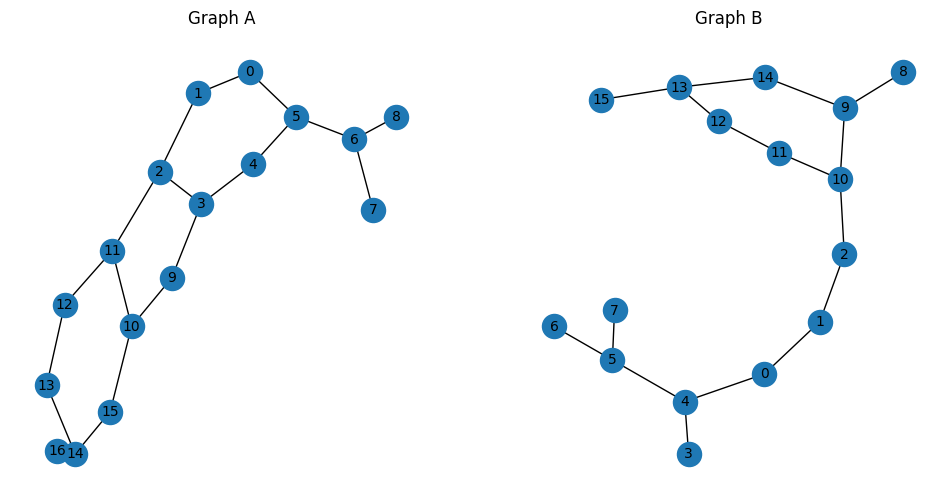

In [147]:
graph_A = dataset[0]
graph_B = dataset[1]

num_nodes = graph_A.num_nodes
edge_list = set(tuple(edge.tolist()) for edge in graph_A.edge_index.T)
remove_node = random.randint(0, num_nodes - 1)
print("Node to remove:", remove_node)
mapping = {old_idx: new_idx for new_idx, old_idx in enumerate(set(range(num_nodes)) - {remove_node})}
edge_list = {(mapping[u], mapping[v]) for u, v in edge_list if u in mapping and v in mapping}

new_x = torch.cat([graph_A.x[:remove_node], graph_A.x[remove_node+1:]], dim=0)
new_edge_index = torch.tensor(list(edge_list), dtype=torch.long).T
print(new_edge_index)
print(new_x.shape)
graph_new = Data(x=new_x, edge_index=new_edge_index)

# ve 2 do thi
G_A = to_networkx(graph_A, to_undirected=True)
G_B = to_networkx(graph_new, to_undirected=True)
pos_A = nx.spring_layout(G_A, seed=42)
plt.figure(figsize=(12, 6)) 
plt.subplot(121)
plt.title("Graph A")
nx.draw(G_A, pos_A, with_labels=True, font_size=10)
plt.subplot(122)
plt.title("Graph B")
nx.draw(G_B, with_labels=True,  font_size=10)
plt.show()